## Debiasing a mixture of gaussians using low-rank debiasing or Stein Thinning

In [1]:
import numpy as np
import jax
import jax.numpy as jnp
import time

from goodpoints.jax.autotune import autotune
from goodpoints.jax.kernel.scalar import imq
from goodpoints.jax.kernel.precond_stein import PrecondSteinKernel
from goodpoints.jax.st import stein_thin
from goodpoints.jax.lr_debias import lr_debias
from goodpoints.jax.mmd import compute_mmd
from goodpoints.jax.distribution import Gaussian, Mixture

jax.config.update('jax_enable_x64', True) # enforce 64-bit floating precision

In [2]:
import logging

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [3]:
# Setting up input distribution and input points.

rng_gen = np.random.default_rng(42)
rng = jax.random.PRNGKey(rng_gen.integers(2**31))
n = 2**16

cov_sqrt1 = rng_gen.normal(size=(2, 2))
cov_sqrt2 = rng_gen.normal(size=(2, 2))
dist1 = Gaussian(np.array([0, 0.5]), 
                cov_sqrt1)
dist2 = Gaussian(np.array([0, 0.5]), 
                cov_sqrt2)
mixture = Mixture([dist1, dist2], weights=np.array([0.5, 0.5]))

rng, p_rng = jax.random.split(rng)
p, choices = mixture.sample_with_choices(p_rng, n)
s = jax.vmap(dist1.score)(p)
hess_fn = jax.jacfwd(dist1.score)

2024-05-15 12:25:06,606 - INFO - Unable to initialize backend 'cuda': jaxlib/cuda/versions_helpers.cc:98: operation cuInit(0) failed: CUDA_ERROR_NO_DEVICE
2024-05-15 12:25:06,607 - INFO - Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: CUDA
2024-05-15 12:25:06,609 - INFO - Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
2024-05-15 12:25:06,609 - WARNING - CUDA backend failed to initialize: jaxlib/cuda/versions_helpers.cc:98: operation cuInit(0) failed: CUDA_ERROR_NO_DEVICE (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [4]:
# Create the mean-zero kernel using automatic tuning heuristics.

tuned_params = autotune(p, scores=s,
                        hess_fn=hess_fn)
kernel = PrecondSteinKernel(imq, 
                            M=tuned_params['M'],
                            med_sqr=tuned_params['med_sqr'])
points = kernel.prepare_input(p, s)

In [5]:
# Run the debiasing algorithm.

alg = 'st' # 'lr' for low-rank debiasing and 'st' for Stein Thinning debiasing

start_time = time.time()
if alg == 'lr':
    w, supp, loss_traj = lr_debias(
        kernel, points, rank=int(np.sqrt(n)),
        num_adapt=3,
        num_iter=5*int(np.sqrt(n)),
        rng_gen=rng_gen,
        use_float64=False,
        correct_diag=True)
else:
    assert(alg == 'st')
    w, supp = stein_thin(kernel, points, n, weight_type='integer')
    supp = np.unique(supp)
print(f'Elapsed: {time.time() - start_time}s')

Elapsed: 175.15641713142395s


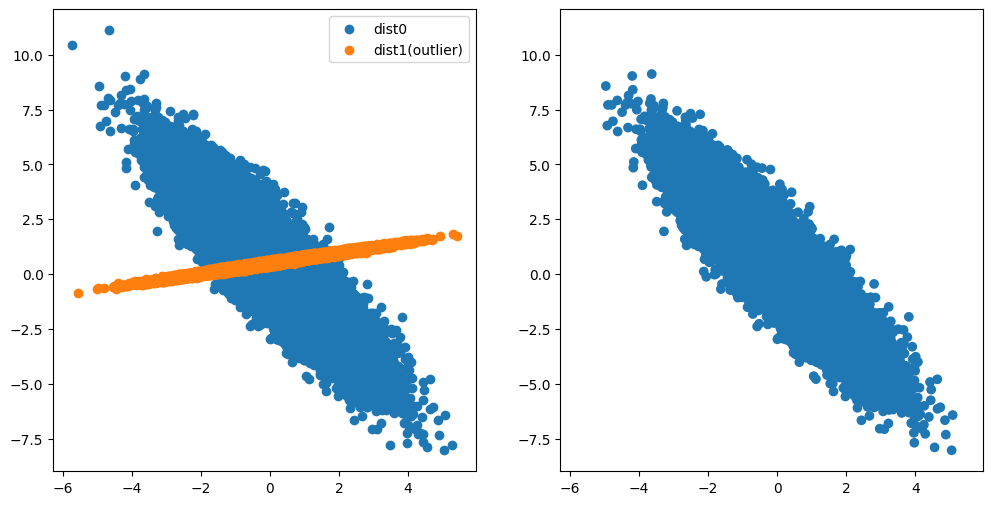

In [6]:
import matplotlib.pyplot as plt

def plot():
    figsize = 6
    fig, axes = plt.subplots(1, 2, figsize=(figsize*2,figsize))
    axes[0].scatter(p[choices==0, 0], p[choices==0, 1], label='dist0')
    axes[0].scatter(p[choices==1, 0], p[choices==1, 1], label='dist1(outlier)')
    axes[0].legend()
    axes[1].scatter(p[:, 0], p[:, 1], alpha=np.minimum(1, w * n))
    plt.setp(axes, xlim=axes[0].get_xlim(), ylim=axes[0].get_ylim())
plot()

In [7]:
mmd_P = compute_mmd(kernel, points.subset(supp), w1=w[supp], mode='mean-zero')
print(f'MMD to P: {mmd_P}')

MMD to P: 7.77498339538777e-09
